# Problem Statement

Data Link -->https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

## Dataset Information:

The dataset contains 45,000 records and 14 variables, each described below:

Column	Description	Type
person_age	Age of the person	Float
person_gender	Gender of the person	Categorical
person_education	Highest education level	Categorical
person_income	Annual income	Float
person_emp_exp	Years of employment experience	Integer
person_home_ownership	Home ownership status (e.g., rent, own, mortgage)	Categorical
loan_amnt	Loan amount requested	Float
loan_intent	Purpose of the loan	Categorical
loan_int_rate	Loan interest rate	Float
loan_percent_income	Loan amount as a percentage of annual income	Float
cb_person_cred_hist_length	Length of credit history in years	Float
credit_score	Credit score of the person	Integer
previous_loan_defaults_on_file	Indicator of previous loan defaults	Categorical
loan_status (target variable)	Loan approval status: 1 = approved; 0 = rejected	Integer

## Project Objective:
To build stimulating predictive modeling processes for loan approval and credit scoring.

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score,precision_score,recall_score,f1_score
import warnings
warnings.filterwarnings('ignore')

Dataset shape: (45000, 14)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int

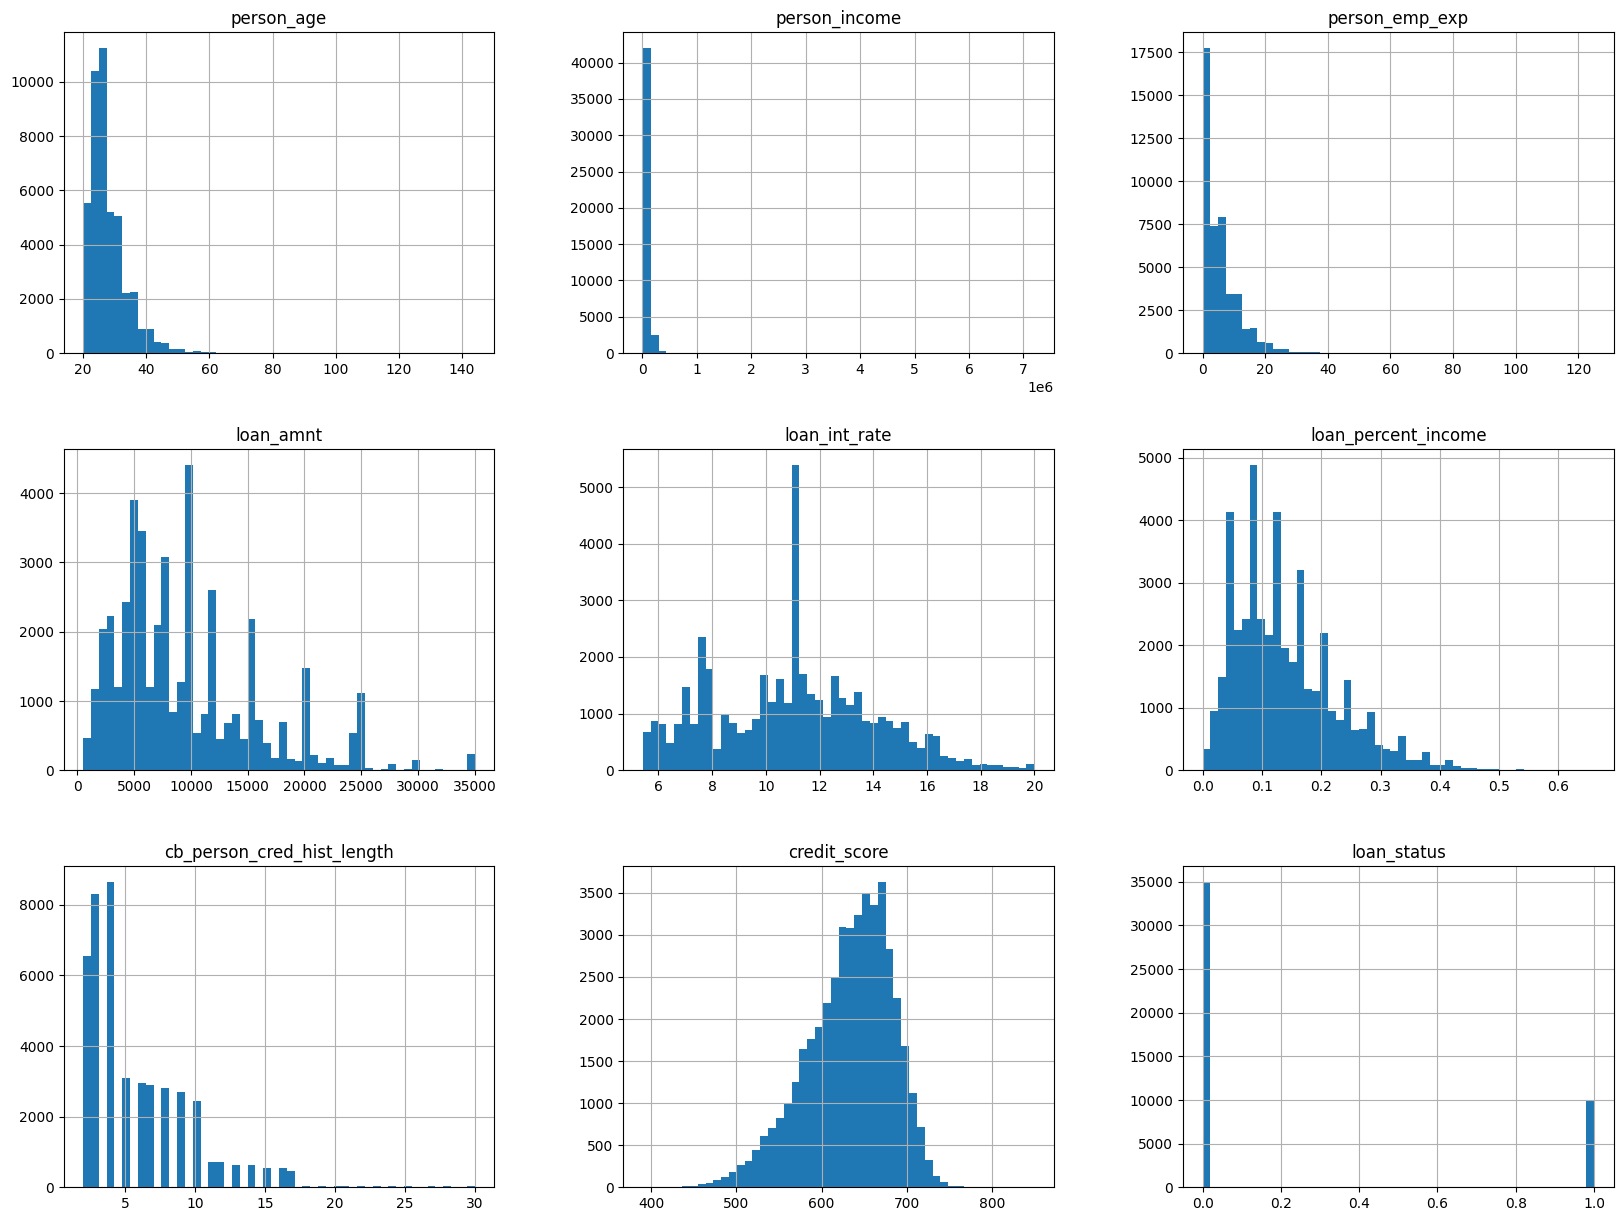

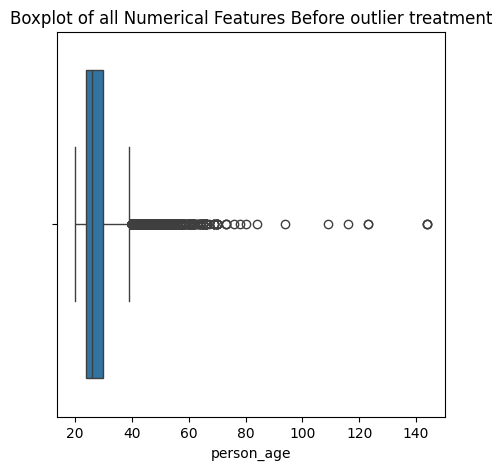

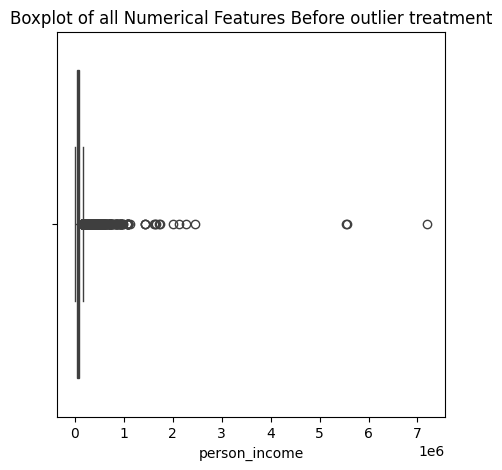

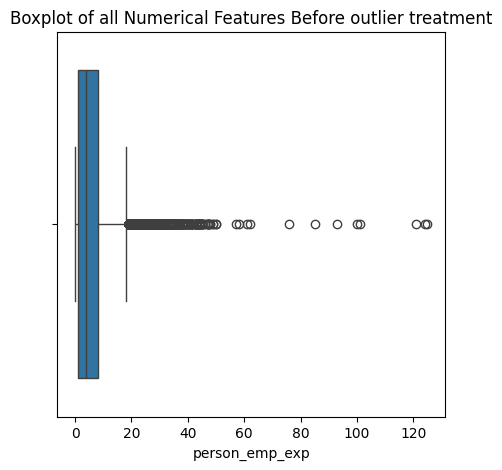

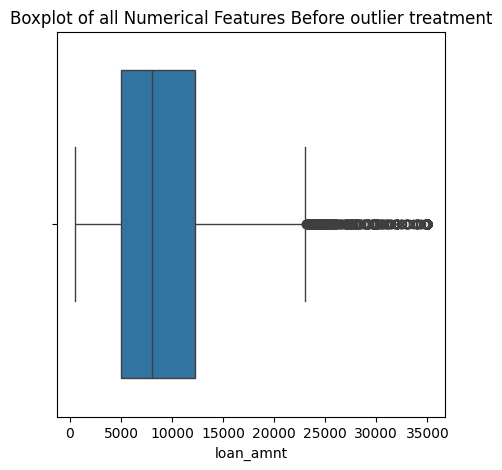

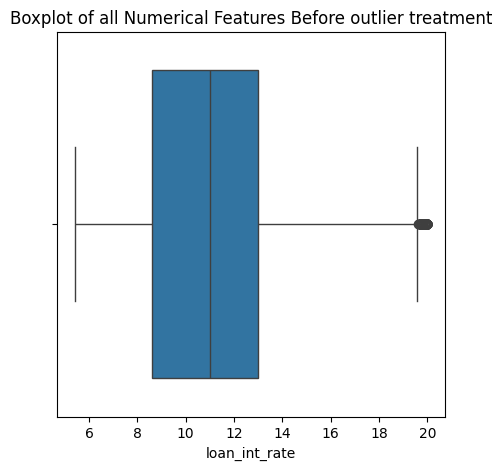

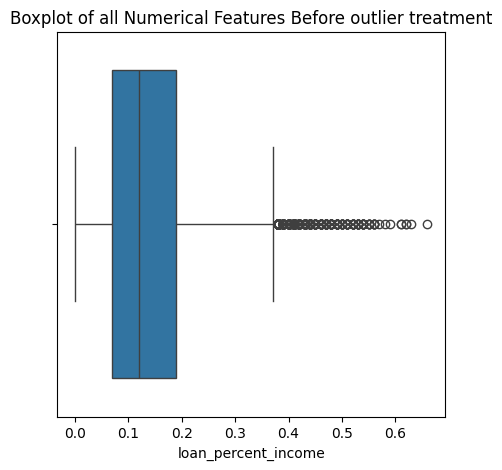

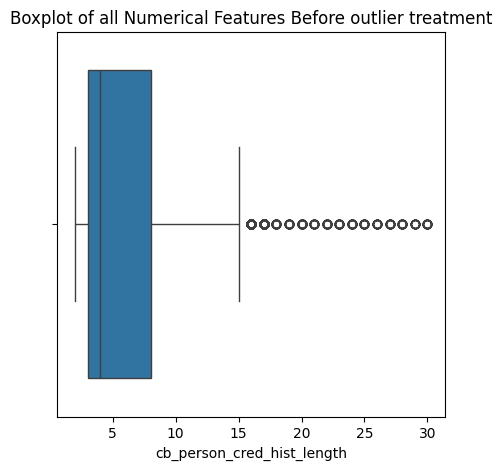

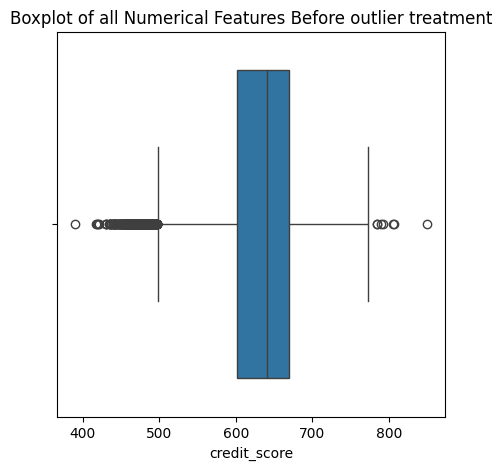

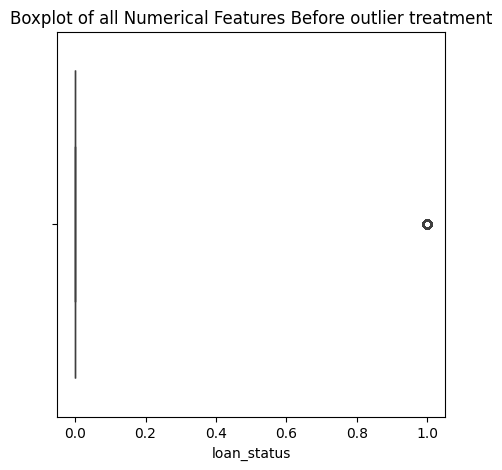


 Almost all the features tend to havev outliers and they have to be cleaned


In [4]:
# ========================================================================
# STEP 1: LOAD AND EDA
# ========================================================================

df=pd.read_csv(r'C:\Users\Admin\Desktop\DV assignments\project\loan_data.csv')
print(f"Dataset shape: {df.shape}")

#Basic Information about the dataset
print("\nDataset info:")
print(df.info())

print("\n First 5 rows:")
print(df.head())

#summary statistics
print("\n Understanding the statistics of Numerical Features:")
print(df.describe())

#visualizing the distribution of featrures
df.hist(bins=50, figsize=(20,15))
plt.show()


#visualizing the outliers through boxplots:
for i in df.select_dtypes(include=['float', 'int64']).columns:
    plt.figure(figsize=(5,5))
    sns.boxplot(data=df, x=i)
    plt.title('Boxplot of all Numerical Features Before outlier treatment')
    plt.show()
print("\n Almost all the features tend to havev outliers and they have to be cleaned")


Missing values per column:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

 No missing values found


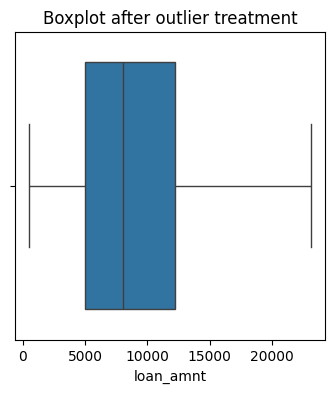

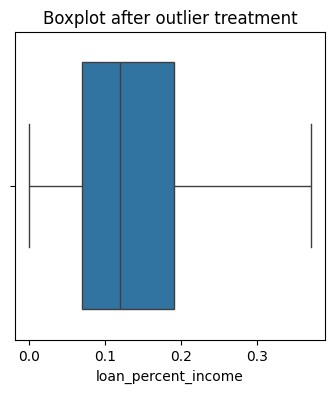

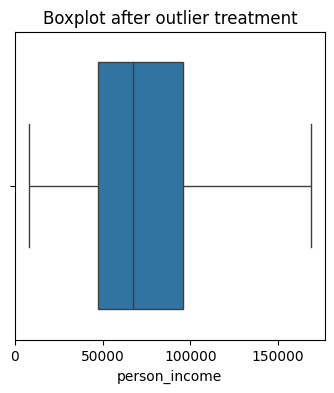

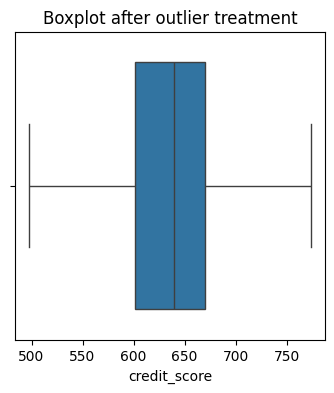

In [3]:
# ========================================================================
# STEP 2: DATA CLEANING
# ========================================================================

#checking for missing values:
print(f"Missing values per column:")
print(df.isnull().sum())
print("\n No missing values found")

#outlier treatment
#creating a new data from the original
df_clean=df.copy()

#discrete variables
#1.person_age - seems to have unrealisitc age
df_clean=df_clean[df_clean['person_age']<=80]

#2.Perosn_emp_exp - Employee experience cannot be greater than employee age
df_clean = df_clean[df_clean['person_emp_exp'] <= df_clean['person_age']]

#continusous variables:
#Capping through IQR method - to preserve distibution,minimal distortion
cols_to_cap = df_clean[['loan_amnt', 'loan_percent_income', 'person_income','credit_score']]

for col in cols_to_cap:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound,
                             np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col]))

#not cleaned - loan_int_rate as the distribution is normal and very very minimal outlier is found

for col in cols_to_cap:
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df_clean,x=df_clean[col])
    plt.title("Boxplot after outlier treatment")
    plt.show()

# Update to the main dataset
df = df_clean.copy()

In [4]:
# ========================================================================
# STEP 3: FEATURE ENGINEERING
# ========================================================================
# Create new features
df_features = df.copy()

# 1. Age groups
df_features['age_group'] = pd.cut(df_features['person_age'], 
                                 bins=[19, 22, 24, 100], 
                                 labels=['Young', 'Mid', 'Older'])

# 2. Income brackets (quintiles)
df_features['income_bracket'] = pd.qcut(df_features['person_income'], 
                                       q=5, 
                                       labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])

# 3. Employment experience categories
df_features['emp_exp_category'] = pd.cut(df_features['person_emp_exp'],
                                        bins=[-1, 0, 2, 100],
                                        labels=['No_Experience', 'Little_Experience', 'Experienced'])

# 4. Credit score categories
df_features['credit_score_category'] = pd.cut(df_features['credit_score'],
                                            bins=[0, 580, 620, 660, 1000],
                                            labels=['Poor', 'Fair', 'Good', 'Excellent'])

# 5. High risk loan indicator
df_features['high_risk_loan'] = ((df_features['loan_int_rate'] > df_features['loan_int_rate'].median()) & 
                                (df_features['loan_percent_income'] > df_features['loan_percent_income'].median())).astype(int)

# 6. Debt to income risk category
df_features['debt_income_risk'] = pd.cut(df_features['loan_percent_income'],
                                        bins=[0, 0.2, 0.4, 1.0],
                                        labels=['Low_Risk', 'Medium_Risk', 'High_Risk'])

In [5]:
# ========================================================================
# STEP 4: DATA PREPROCESSING
# ========================================================================

X=df_features.drop(['loan_status'],axis=1)
y=df_features['loan_status']

#encoding the variables
#Label Encoding ---> It was chosen as it converts each category into a unique integer and well compatible for project's models.
#categorical Columns in 'X'"Assignment 2.ipynb"
x_category=X.select_dtypes(include=['object','category']).columns
print(f"Number of categorical in X:", len(x_category))
print(x_category.to_list())

x_encoded=X.copy()
for col in x_category:
    le = LabelEncoder()
    x_encoded[col] = le.fit_transform(X[col])



Number of categorical in X: 10
['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file', 'age_group', 'income_bracket', 'emp_exp_category', 'credit_score_category', 'debt_income_risk']


In [6]:
# ========================================================================
# STEP 5: SPLIT DATA INTO TRAINING AND TEST SETS
# ========================================================================

X_train,X_test,y_train,y_test=train_test_split(x_encoded,y,test_size=0.2,random_state=42)

#Scaling the numerical variables
numerical_cols=X_train.select_dtypes(include=['int','float']).columns
ss=StandardScaler()
X_train_scaled=ss.fit_transform(X_train[numerical_cols])
X_test_scaled=ss.transform(X_test[numerical_cols])
#Only transforming the test set as it leads to data leakage by learning the parameters while fitting

In [7]:
# ========================================================================
# STEP 6: BUILD AND COMPARE MULTIPLE MODELS
# ========================================================================

#1.Logistic Regression
print("\n Training Logistic Regression...")
log_reg=LogisticRegression(random_state=42,max_iter=1000)
log_reg.fit(X_train_scaled,y_train)

 # Cross-validation
cv_scores_lr=cross_val_score(log_reg,X_train_scaled,y_train,cv=5,scoring='accuracy')

#preditctions
y_pred_lr=log_reg.predict(X_test_scaled)
test_accuracy_lr=accuracy_score(y_test,y_pred_lr)
r2_lr=r2_score(y_test,y_pred_lr)


print(f"cross_validation_score: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std()*2:.4f})")
print(f"Test accuracy: {test_accuracy_lr:.4f}")


#2.Random Forest
print("\n Training Random Forest...")
rf=RandomForestClassifier(random_state=42,n_estimators=100)
rf.fit(X_train,y_train)

#Cross-validation
cv_scores_rf=cross_val_score(rf,X_train,y_train,cv=5,scoring='accuracy')

#prediction
y_pred_rf=rf.predict(X_test)
test_accuracy_rf=accuracy_score(y_test,y_pred_rf)


print(f"cross_validation_score: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")
print(f"Test accuracy: {test_accuracy_rf:.4f}")


#3.Gradient Boosting
print("\n Training Gradient Boosting...")
gb=GradientBoostingClassifier(random_state=42,n_estimators=100)
gb.fit(X_train,y_train)

#Cross-validation
cv_scores_gb=cross_val_score(gb,X_train,y_train,cv=5,scoring='accuracy')

#prediction
y_pred_gb=gb.predict(X_test)
test_accuracy_gb=accuracy_score(y_test,y_pred_gb)

print(f"cross_validation_score: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std()*2:.4f})")
print(f"Test accuracy: {test_accuracy_gb:.4f}")


print("\n The best model is Random Forest")
print(f"Test Accuracy of Random Forest: {test_accuracy_rf}")




 Training Logistic Regression...
cross_validation_score: 0.8941 (+/- 0.0088)
Test accuracy: 0.8931

 Training Random Forest...
cross_validation_score: 0.9236 (+/- 0.0029)
Test accuracy: 0.9225

 Training Gradient Boosting...
cross_validation_score: 0.9213 (+/- 0.0036)
Test accuracy: 0.9209

 The best model is Random Forest
Test Accuracy of Random Forest: 0.9225469496610734


In [8]:
# ========================================================================
# STEP 7: EVALUATING THE PERFORMANCE THROUGH METRICES OF RANDOM FOREST 
# ========================================================================
cm=confusion_matrix(y_test,y_pred_rf)
TN,FP,FN,TP= cm.ravel()

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
specificity = TN / (TN + FP)
r2_rf = r2_score(y_test, y_pred_rf)

print('Confusion Matrix:')
print(cm)
print(f'TN={TN}, FP={FP}, FN={FN}, TP={TP}\n')

print(f'Accuracy    : {accuracy:.4f}')
print(f'Precision   : {precision:.4f}')
print(f'Recall      : {recall:.4f}')
print(f'Specificity : {specificity:.4f}')
print(f'F1 Score    : {f1:.4f}')
print(f"r2_score    : {r2_rf: .4f}")

#evaluating if the model is overfitted or not
train_pred=rf.predict(X_train)
test_pred=rf.predict(X_test)

train_accuracy=accuracy_score(y_train,train_pred)
test_accuracy=accuracy_score(y_test,test_pred)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:",  test_accuracy)
#there is overfitting and it has to be taken care of

print("\n There is presence of Class Imbalance:")
print(f"Recall: {recall}")

print("\n Calculating Class wise Accuracy on Test Data")
cm_test=confusion_matrix(y_test,test_pred)

#Class-0 Accuracy (non-default):
class_0_acc=cm_test[0,0]/(cm_test[0,0]+cm_test[0,1])
print(f"class_0_acc:{class_0_acc}")

#Class-1 Accuracy (default):
class_1_acc=cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])
print(f"class_1_acc:{class_1_acc}")
#Deep trees split until they perfectly fit the training data,But on unseen test data, performance drops so evaluating on test data

print("As this is a credit_risk project it is very important Class 1 has good accuracy, as it predicts defaulters so it has to be imporved")


print("\n Handling Class Imbalances...")
#class 1 accuracy is low
#S.M.O.T.E Technique -> one of the most effective and widely used technique

from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.6,random_state=44)
X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

#evaluating if the model after smote:
train_pred=rf.predict(X_train_smote)
test_pred=rf.predict(X_test)

#confusion matrix
train_accuracy=accuracy_score(y_train_smote,train_pred)
test_accuracy=accuracy_score(y_test,test_pred)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:",  test_accuracy)



Confusion Matrix:
[[6786  201]
 [ 496 1516]]
TN=6786, FP=201, FN=496, TP=1516

Accuracy    : 0.9225
Precision   : 0.8829
Recall      : 0.7535
Specificity : 0.9712
F1 Score    : 0.8131
r2_score    :  0.5538
Train Accuracy: 0.9999722160480107
Test Accuracy: 0.9225469496610734

 There is presence of Class Imbalance:
Recall: 0.7534791252485089

 Calculating Class wise Accuracy on Test Data
class_0_acc:0.9712322885358523
class_1_acc:0.7534791252485089
As this is a credit_risk project it is very important Class 1 has good accuracy, as it predicts defaulters so it has to be imporved

 Handling Class Imbalances...
Train Accuracy: 0.9567915011382404
Test Accuracy: 0.9225469496610734


In [9]:
# ========================================================================
# STEP 8: HYPERPARAMETER TUNING
# ========================================================================

print("\n HYPER-PARAMETER TUNING USING OPTUNA...")
import optuna

# objective function
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    # Use cross-validation on the training data
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

#creating study
study=optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective,n_trials=50)

#selecting the best parameters
study.best_params





 HYPER-PARAMETER TUNING USING OPTUNA...


[I 2025-10-06 13:02:30,343] A new study created in memory with name: no-name-19e8d379-8984-432f-afd2-f897d7089105
[I 2025-10-06 13:02:38,361] Trial 0 finished with value: 0.920482250547264 and parameters: {'n_estimators': 81, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.920482250547264.
[I 2025-10-06 13:02:50,175] Trial 1 finished with value: 0.9196765051313577 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.920482250547264.
[I 2025-10-06 13:02:53,754] Trial 2 finished with value: 0.8958378557614716 and parameters: {'n_estimators': 44, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.920482250547264.
[I 2025-10-06 13:02:55,121] Trial 3 finished with value: 0.8944489159833253 and parameters: {'n_estimators': 36, 'max_depth': 4, 'min_samples_

{'n_estimators': 16,
 'max_depth': 25,
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_features': None}

In [10]:
best_params=study.best_params

print("\n Training the Final model with The Best Parameters...")
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_smote, y_train_smote)


#Final Evaluation on the model
final_preds = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds)
print("\nFinal TEST accuracy:", f"{final_acc:.4f}")


 Training the Final model with The Best Parameters...

Final TEST accuracy: 0.9061


# Conclusion:

The final Random Forest model achieves about 90.61% test accuracy with consistent cross‑validation scores, indicating good generalization for loan approval prediction. Income, loan_percent_income, credit_score, and high_risk_loan features emerge as key drivers, matching typical credit‑risk intuition. This model can help a bank quickly approve low‑risk customers while flagging applicants with high debt‑to‑income ratios, low credit scores, or prior defaults for closer review.